In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

In [2]:
%matplotlib notebook

In [4]:
spec = h5py.File('../../../Data/chrisspec/res-1000-1years_full_id1.h5', 'r')

In [6]:
len(spec['active'][:,0])

730

<IPython.core.display.Javascript object>


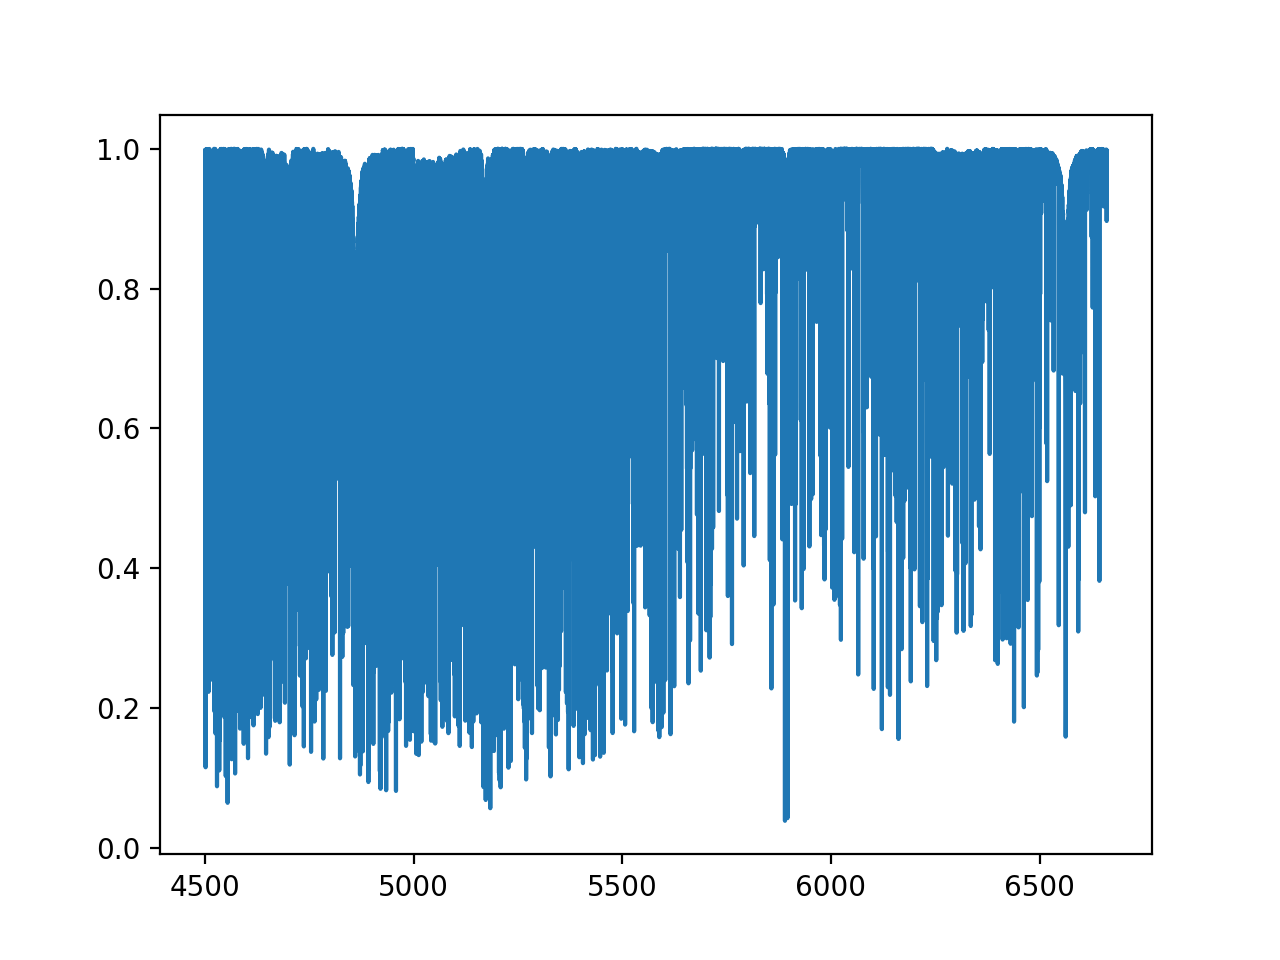

In [5]:
t = 10
wvl = np.array(spec['lambdas'])
flx = np.array(spec['active'][t,:]/np.max(spec['active'][t,:]))
tempflx = np.array(spec['quiet']/np.max(spec['quiet']))
keep = np.where((flx > 0.00001) & (wvl > 4500))[0]
plt.plot(wvl[keep], flx[keep])
plt.show()

<IPython.core.display.Javascript object>


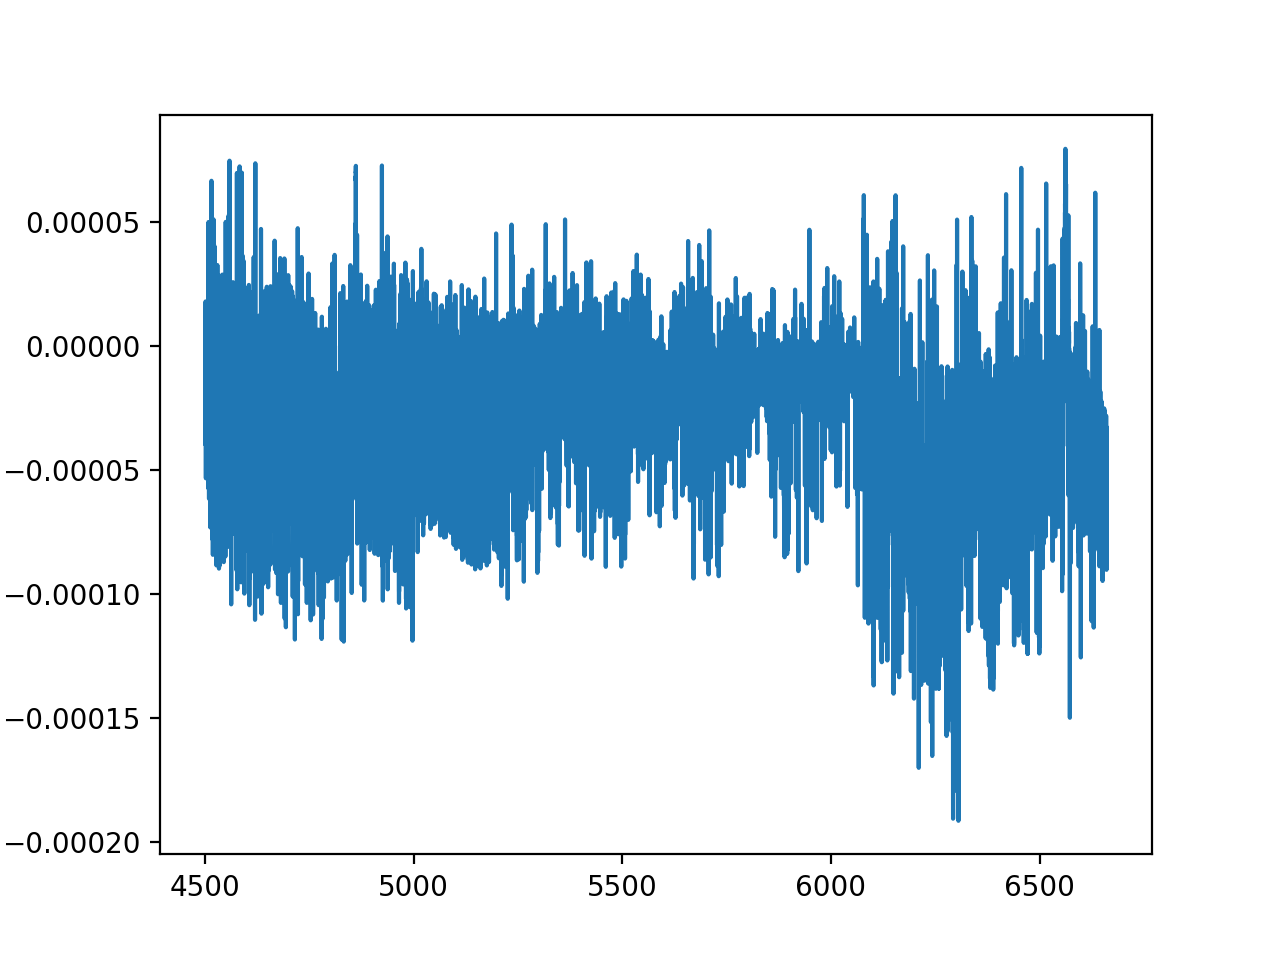

In [5]:
plt.plot(wvl[keep], flx[keep] - tempflx[keep])
plt.show()

<IPython.core.display.Javascript object>


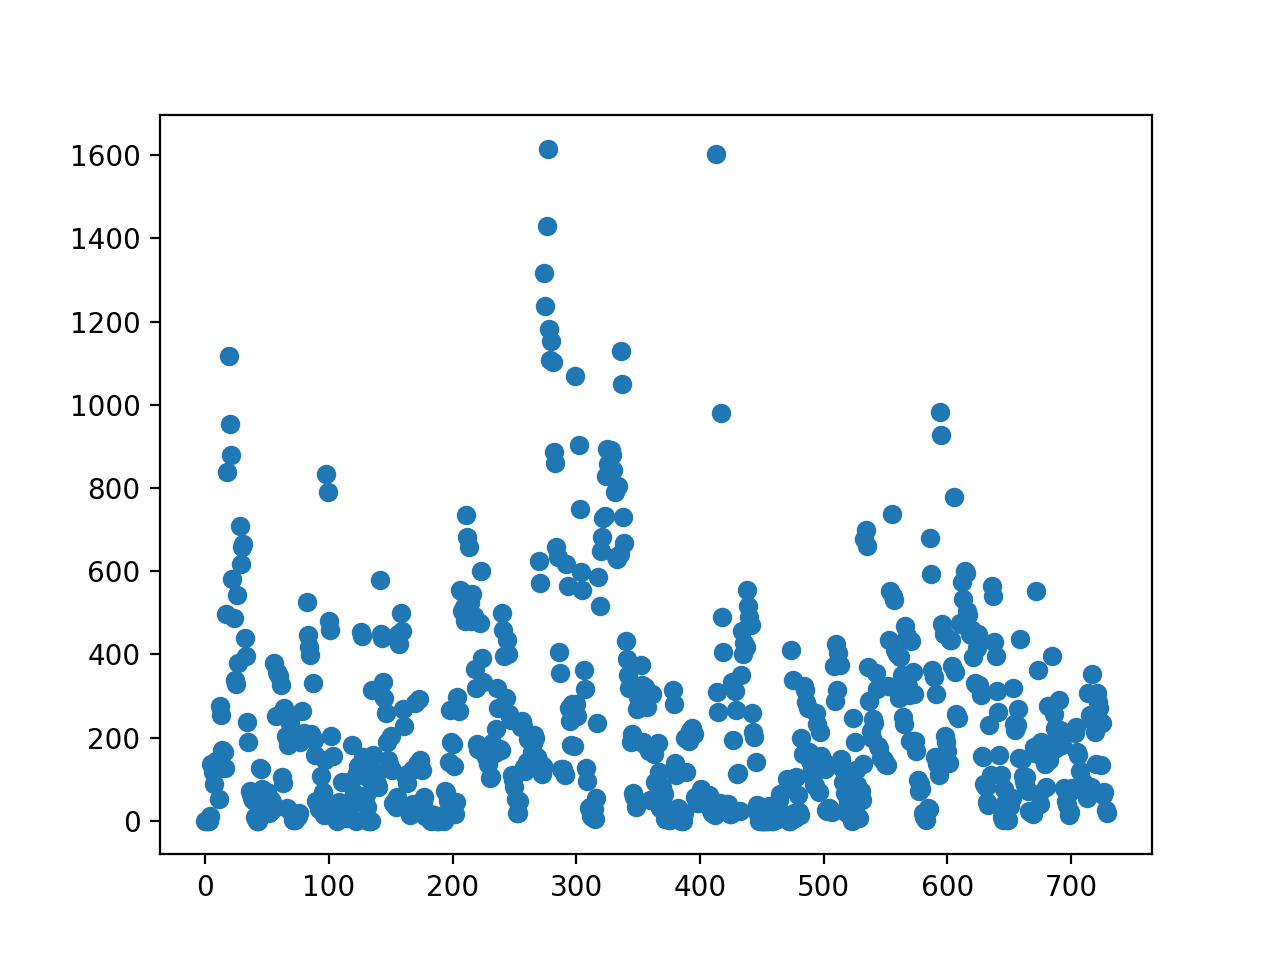

In [6]:
plt.scatter(np.arange(730), spec['msh_vis_proj'])
plt.show()

In [7]:
keep = np.where(np.array(spec['msh_visible']) > 0)[0]
scaling = np.max(np.array(spec['msh_vis_proj'])[keep]/np.array(spec['msh_visible'])[keep])
scaling

0.49287222227484395

<IPython.core.display.Javascript object>


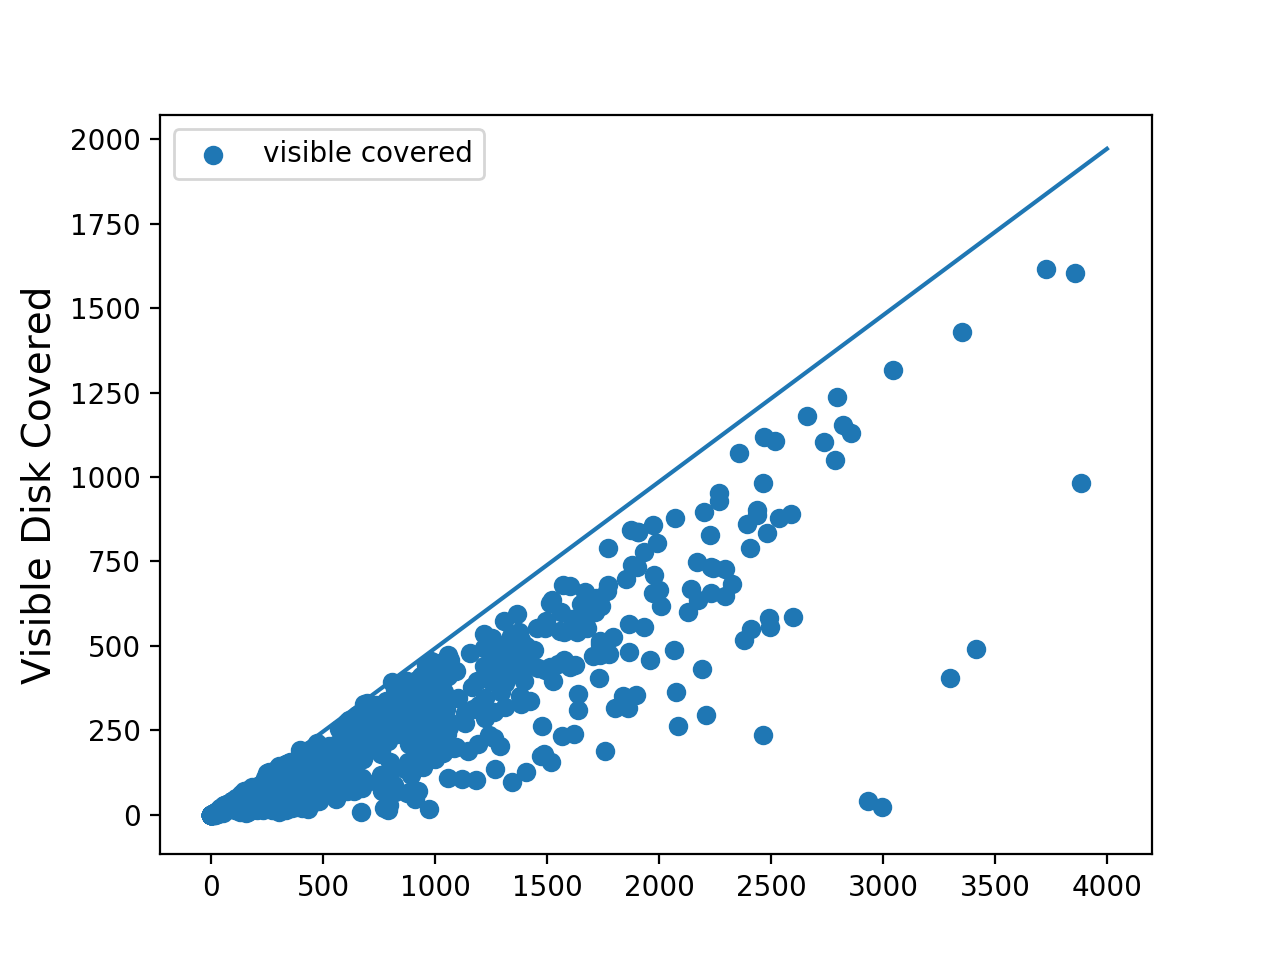

In [8]:
x = np.linspace(0, 4000, 10)
plt.plot(x, scaling*x)
#plt.scatter(spec['msh_covered'], spec['msh_vis_proj'], label='total covered')
plt.scatter(spec['msh_visible'], spec['msh_vis_proj'], label='visible covered')
plt.ylabel("Visible Disk Covered", fontsize=14)
plt.legend(loc='best')
plt.show()

# Simulate Spectra

In [9]:
len(spec['active'][:,0])

730

In [10]:
np.random.seed(8)
tau = np.sort(np.random.choice(np.arange(len(spec['active'][:,0])), size=100, replace=False))

<IPython.core.display.Javascript object>


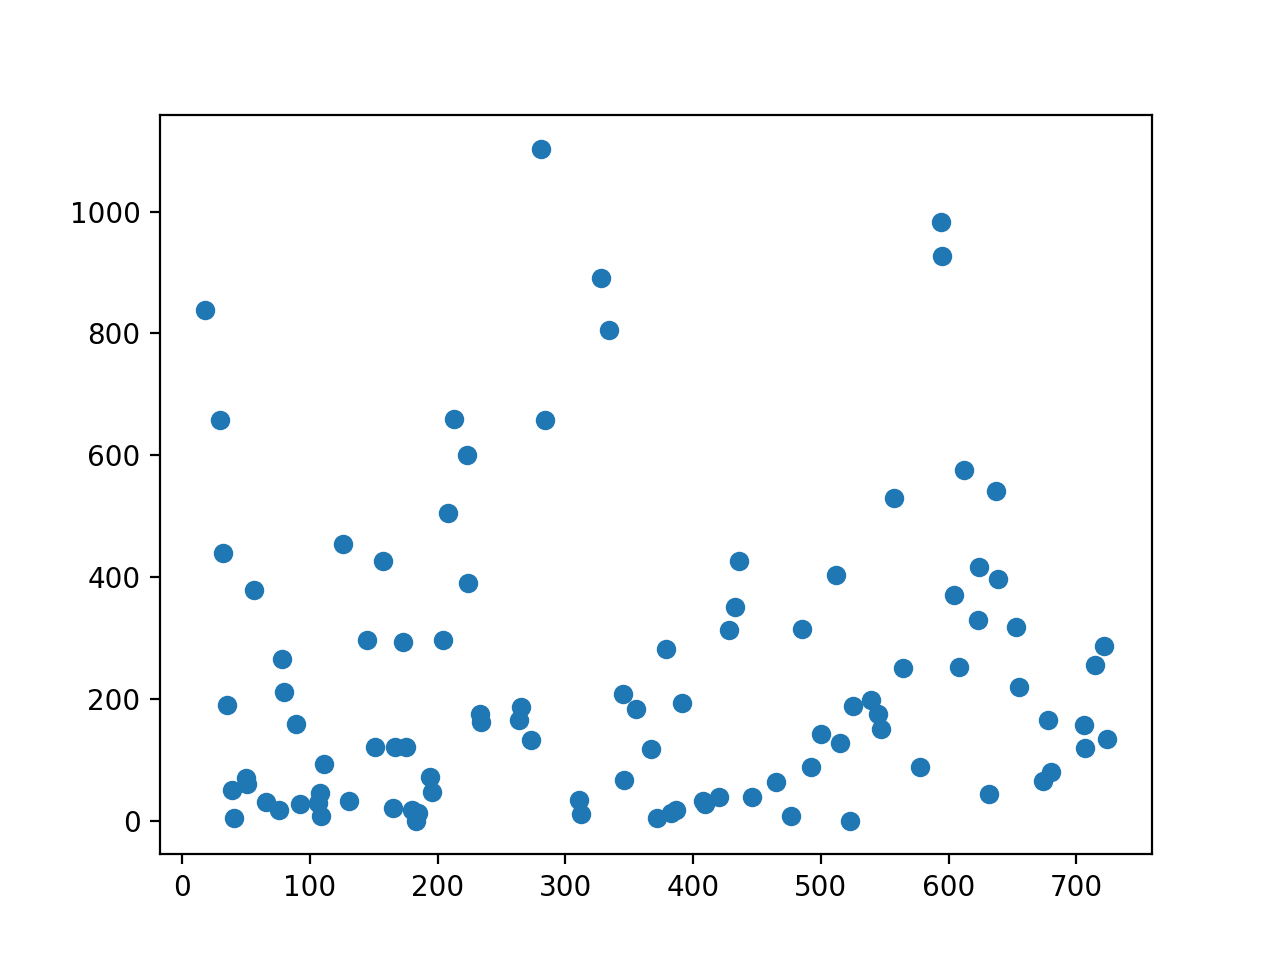

In [11]:
plt.scatter(tau, spec['msh_vis_proj'][tau])
plt.show()

In [12]:
def broaden(wvl, flx, pcount, step, resol):
    fwhm = wvl[pcount]/resol
    disp = wvl[pcount+1] - wvl[pcount]
    nhalf = int(3.3972872*0.5*fwhm/disp)
    gpro = np.sqrt(np.log(2)/np.pi) * disp / (0.5*fwhm) * np.exp(-((np.sqrt(np.log(2))/(0.5*fwhm))*disp*(np.arange(2*nhalf+1) - nhalf))**2)
    if pcount+step <= len(wvl):
        w2 = wvl[pcount+step-1]
    else:
        w2 = wvl[-1]
    ind_pix = np.where((wvl >= wvl[pcount]) & (wvl <= w2))[0]
    step = len(ind_pix)
    ssnip = flx[ind_pix]
    if(pcount == 0):
        spad = np.array([ssnip[0]]*(nhalf+2) + list(ssnip) + list(flx[np.arange(pcount+step-1, pcount+step+nhalf+1)]))
    elif pcount+step+nhalf+2 <= len(wvl):
        spad = np.array(list(flx[np.arange(pcount - nhalf - 3, pcount-1)]) + list(ssnip) + list(flx[np.arange(pcount+step-1, pcount+step+nhalf+1)]))
    else:
        spad = np.array(list(flx[np.arange(pcount - nhalf - 3, pcount-1)]) + list(ssnip) + [ssnip[-1]]*(nhalf+2))
    s_conv = np.convolve(spad, gpro)
    s_conv = s_conv[int((len(s_conv)-step)/2):int(len(s_conv) - int((len(s_conv)-step)/2))]
    return s_conv

import scipy.interpolate as interpolate

def wave_match(wvl1, flx1, targetwvl):
    wvlrng = np.where((targetwvl >= np.min(wvl1)) & (targetwvl <= np.max(wvl1)))[0]
    f = interpolate.interp1d(wvl1, flx1, kind="cubic", fill_value=0)
    return f(targetwvl[wvlrng])

In [13]:
import sys
sys.path.append("../")
from abfeature_functions import lowerSNR

In [14]:
from astropy.io import fits
tauceti = fits.open("../../App_to_EXPRES/HD10700/spectra/10700_191007.1130.fits")

In [42]:
wvl = []
wmin = tauceti[1].data[0][12][0]
for od in range(len(tauceti[0].data[:,0])):
    nonan = np.where(~np.isnan(tauceti[0].data[od,:]))[0]
    keep = np.where(tauceti[1].data[od][12][nonan] > wmin)[0]
    wvl = wvl + list(tauceti[1].data[od][12][nonan][keep])
    wmin = np.max(np.array(wvl))
wvl = np.array(wvl)

In [43]:
wvl = wvl[(wvl > 5000) & (wvl < 6500)]

In [44]:
wvl2 = np.array(spec['lambdas'])
keep = np.where((wvl2 >= 4990) & (wvl2 <= 6510))[0]
tmp = wave_match(wvl2[keep], np.array(spec['quiet']/np.max(spec['quiet']))[keep], wvl)
for t in tau:
    flx0 = np.array(spec['active'][t,keep])
    flx = np.hstack([list(broaden(wvl2[keep], flx0, p, 325, 137500)) 
                     for p in np.arange(0, len(keep), 325)])
    flx = lowerSNR(wave_match(wvl2[keep], flx/np.max(flx), wvl), 250)
    s = pd.DataFrame({"Wavelength": wvl, "Flux": flx, "Uncertainty": 1/np.sqrt(tmp)})
    s.to_csv("chrissim_%d.csv"%int(t))
temp = pd.DataFrame({"Wavelength": wvl, "Flux": tmp})
temp.to_csv("chrissim_template.csv")

# Analyze SAFE

### True template, raw coefficients

In [12]:
safe = pd.read_csv("chrissim_2SAFE.csv")
safe.columns

Index(['Unnamed: 0', 'Filename', 'Pvals', 'SAFE', 'b1', 'b0', 'b2', 'b3', 'b4',
       'b5', 't1', 't0', 't2', 't3', 't4', 't5'],
      dtype='object')

In [9]:
tau2 = np.setdiff1d(tau, [334])
tau2

array([ 18,  30,  32,  35,  39,  41,  50,  51,  56,  66,  76,  78,  80,
        89,  92, 106, 108, 109, 111, 126, 131, 145, 151, 157, 165, 167,
       173, 175, 180, 183, 185, 194, 196, 204, 208, 213, 223, 224, 233,
       234, 264, 265, 273, 281, 284, 311, 312, 328, 345, 346, 355, 367,
       372, 379, 383, 387, 391, 408, 409, 420, 428, 433, 436, 446, 465,
       477, 485, 492, 500, 512, 515, 523, 525, 539, 545, 547, 557, 564,
       578, 594, 595, 604, 608, 612, 623, 624, 632, 637, 639, 653, 655,
       674, 678, 680, 706, 707, 715, 722, 724])

In [7]:
np.array([int(s.split('_')[1].split('.csv')[0]) for s in safe.Filename.values])

array([ 18,  30,  32,  35,  39,  41,  50,  51,  56,  66,  76,  78,  80,
        89,  92, 106, 108, 109, 111, 126, 131, 145, 151, 157, 165, 167,
       173, 175, 180, 183, 185, 194, 196, 204, 208, 213, 223, 224, 233,
       234, 264, 265, 273, 281, 284, 311, 312, 328, 345, 346, 355, 367,
       372, 379, 383, 387, 391, 408, 409, 420, 428, 433, 436, 446, 465,
       477, 485, 492, 500, 512, 515, 523, 525, 539, 545, 547, 557, 564,
       578, 594, 595, 604, 608, 612, 623, 624, 632, 637, 639, 653, 655,
       674, 678, 680, 706, 707, 715, 722, 724])

<IPython.core.display.Javascript object>


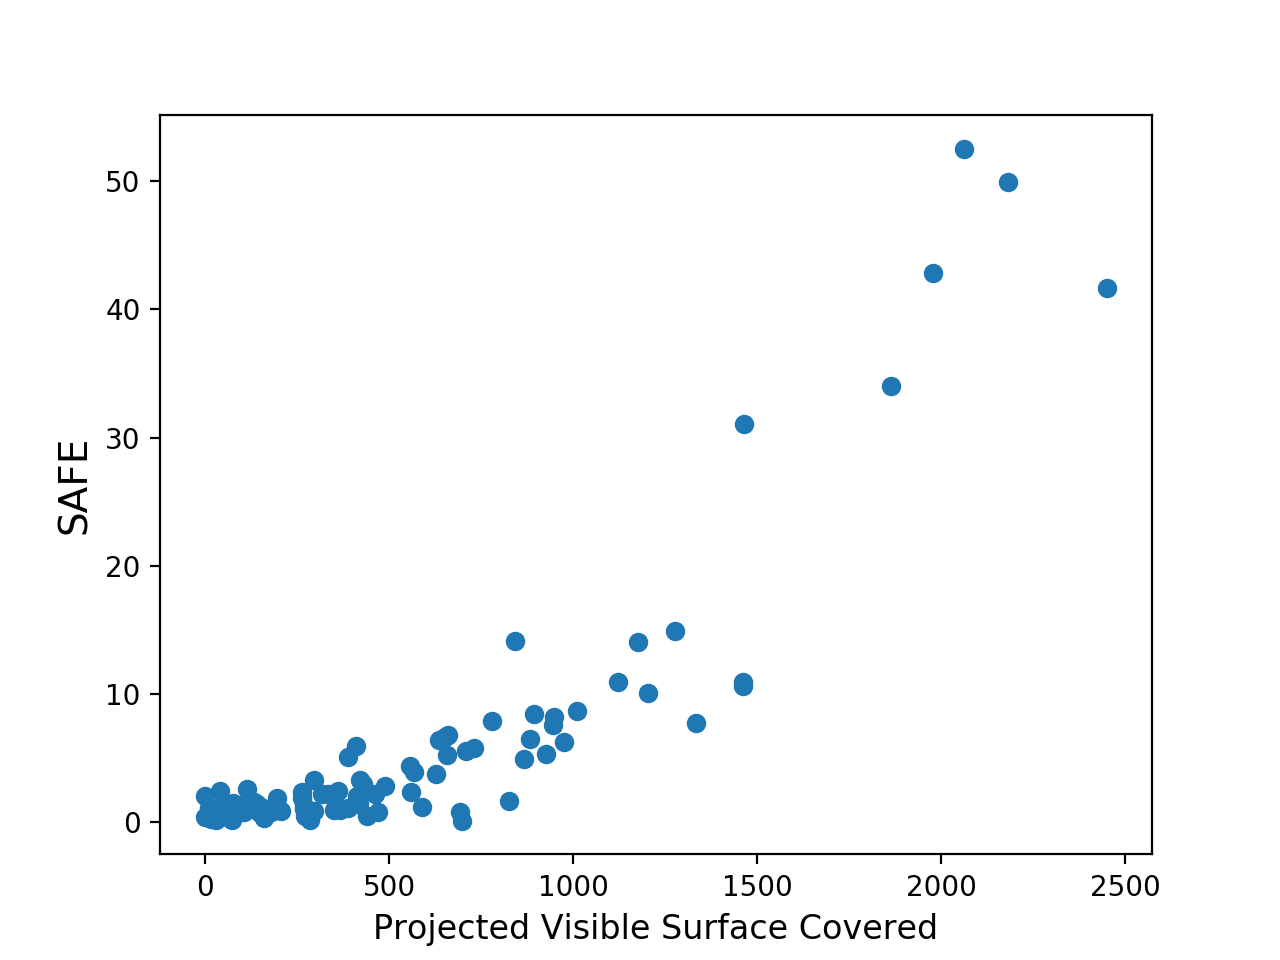

In [11]:
plt.scatter(spec['msh_vis_proj'][tau2]/scaling, safe.SAFE.values)
plt.xlabel("Projected Visible Surface Covered", fontsize=12)
plt.ylabel("SAFE", fontsize=14)
plt.show()

### True template, adjusted coefficients

<IPython.core.display.Javascript object>


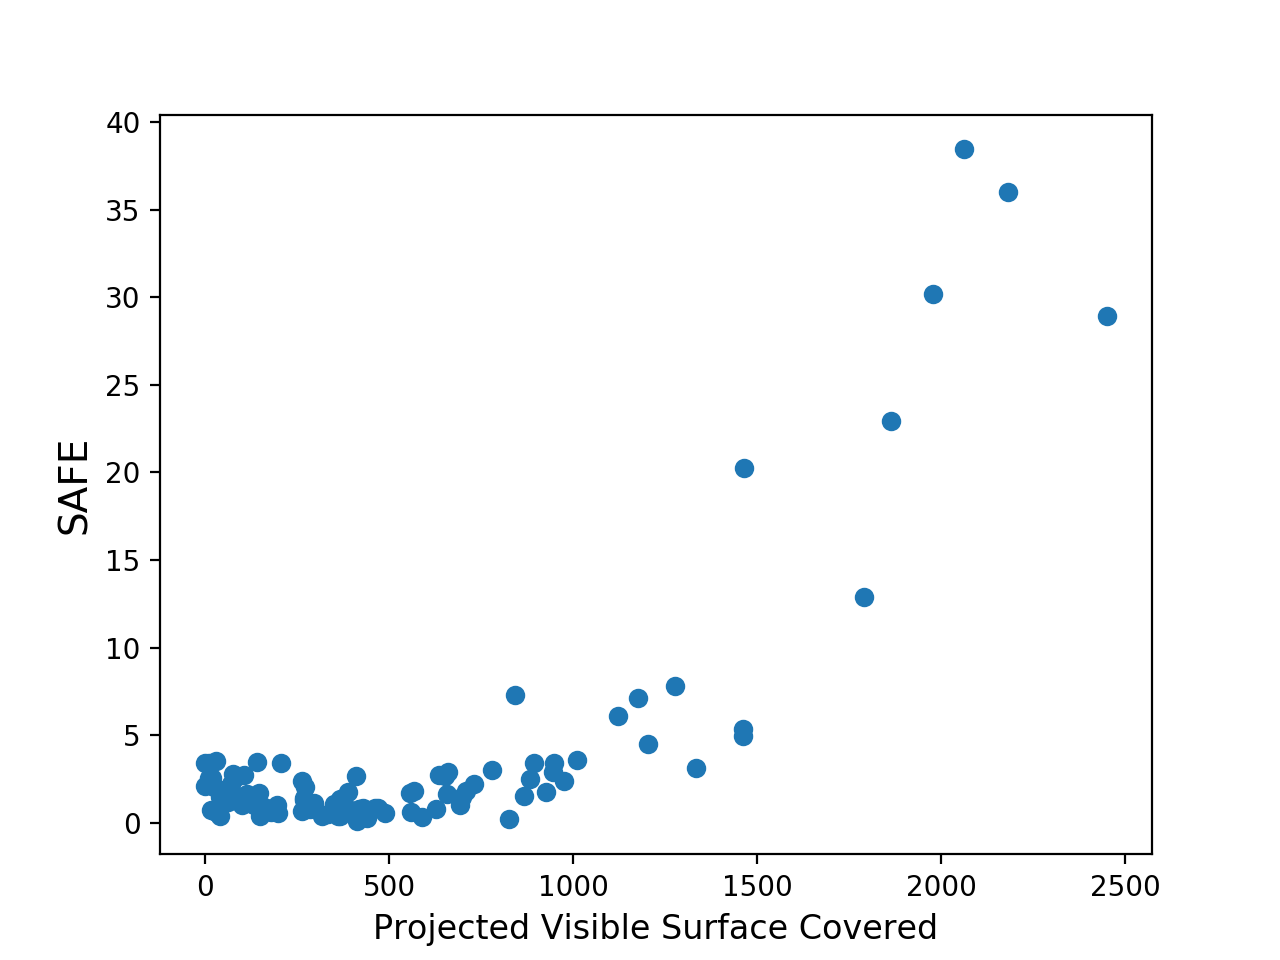

In [12]:
safe2 = pd.read_csv("chrissim_2SAFE_2.csv")
plt.scatter(spec['msh_vis_proj'][tau]/scaling, safe2.SAFE.values)
plt.xlabel("Projected Visible Surface Covered", fontsize=12)
plt.ylabel("SAFE", fontsize=14)
plt.show()

### Estimated template, adjusted coefficients

<IPython.core.display.Javascript object>


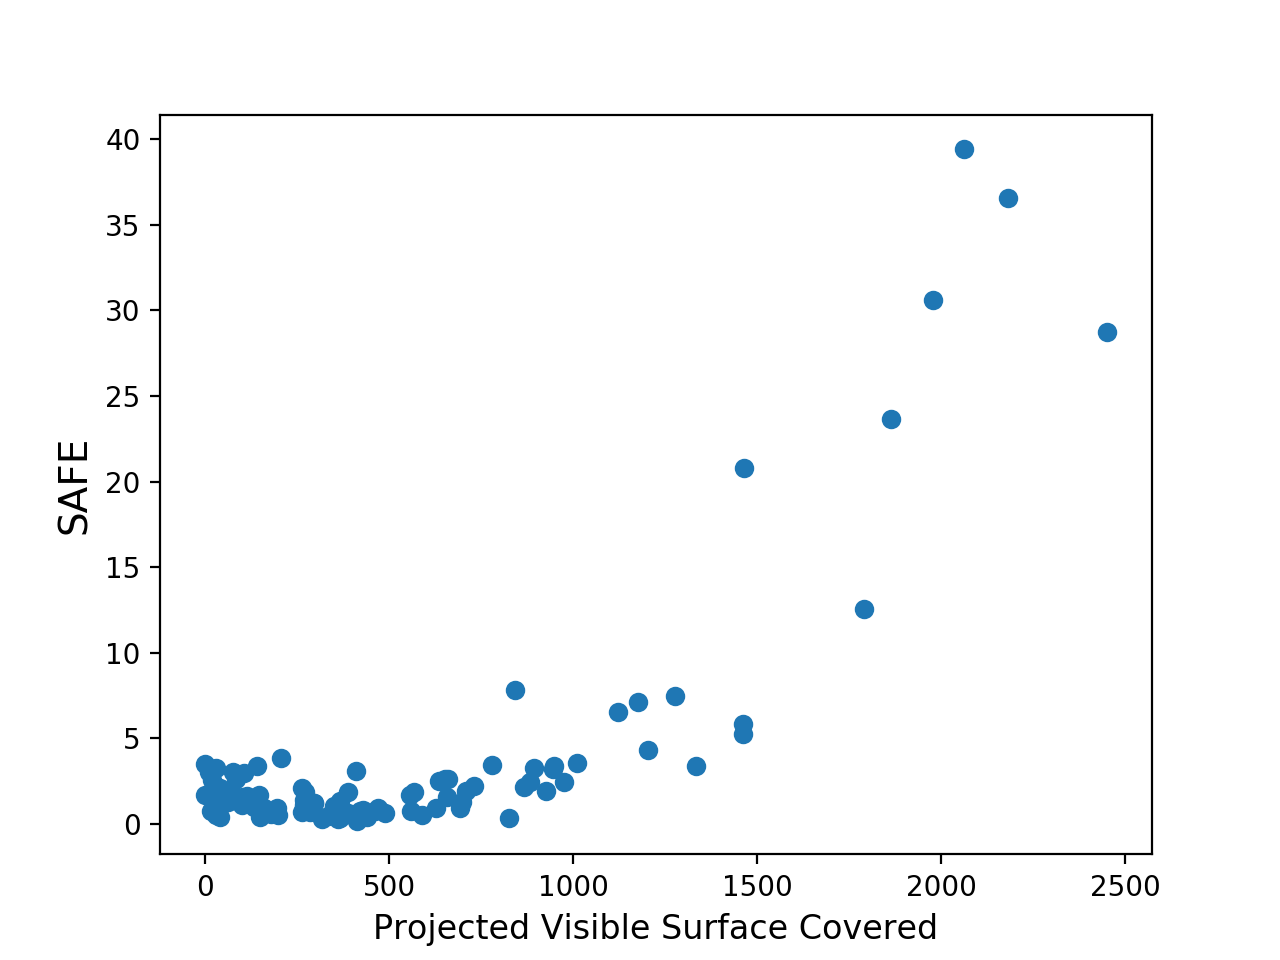

In [13]:
safe3 = pd.read_csv("chrissim_2SAFE_3.csv")
plt.scatter(spec['msh_vis_proj'][tau]/scaling, safe3.SAFE.values)
plt.xlabel("Projected Visible Surface Covered", fontsize=12)
plt.ylabel("SAFE", fontsize=14)
plt.show()

### Estimated template, adjusted coefficients, EXPRES resolution

In [3]:
import scipy.stats as stat

<IPython.core.display.Javascript object>


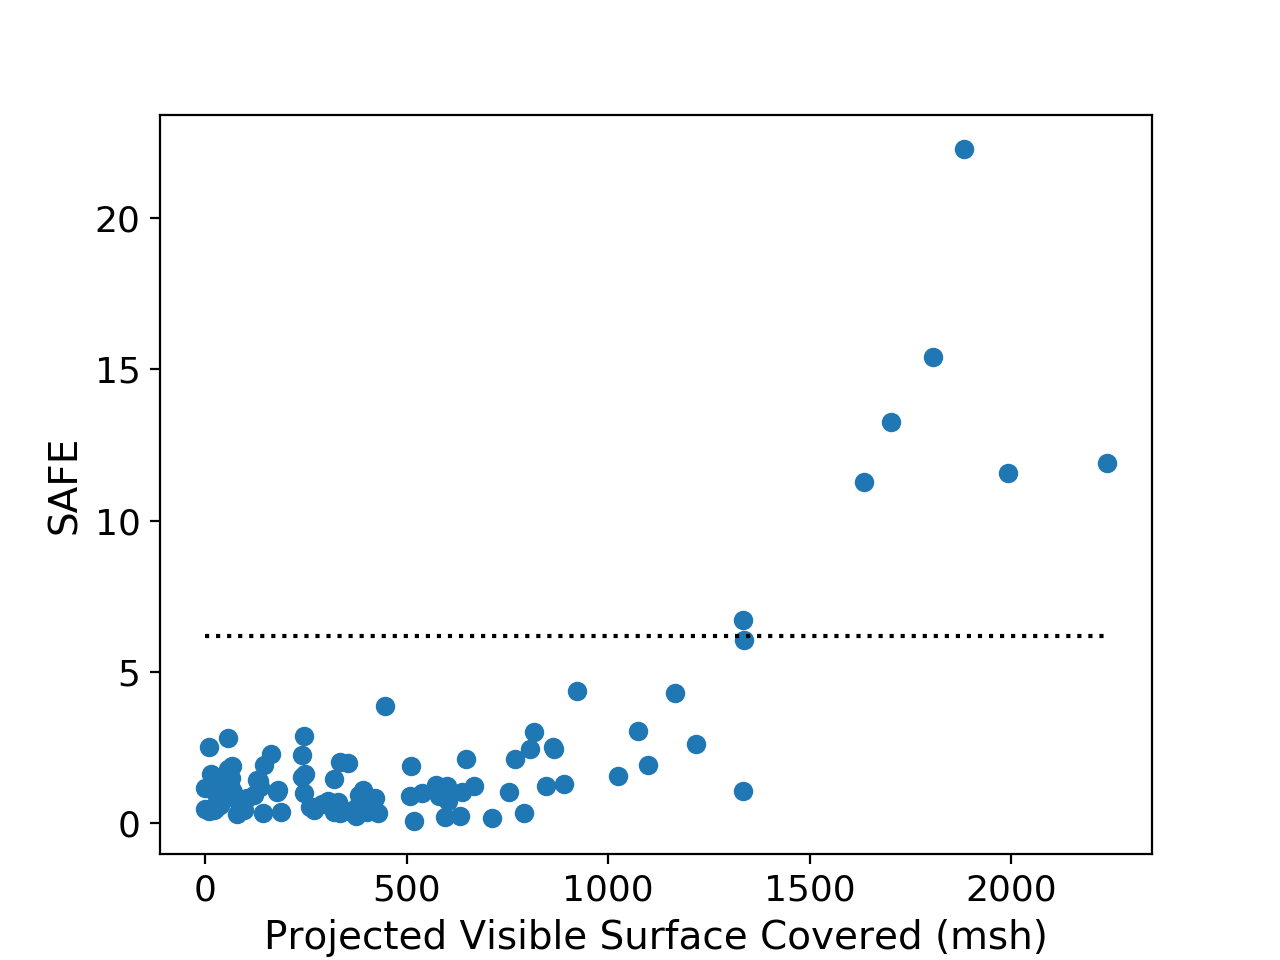

In [13]:
safe5 = pd.read_csv("chrissim_2SAFE_5.csv")
critval = stat.f.ppf(1 - 0.001/(len(safe5.SAFE.values)), dfn = 5, dfd = 33020-6)
plt.scatter(spec['msh_vis_proj'][tau]/scaling, safe5.SAFE.values)
plt.hlines(critval, xmin=0, xmax=np.max(spec['msh_vis_proj'][tau]/scaling), ls=':')
plt.xlabel("Projected Visible Surface Covered (msh)", fontsize=14)
plt.ylabel("SAFE", fontsize=14)
plt.tick_params(axis='both', labelsize=13)
plt.savefig("safe_vs_msh.pdf", format='pdf')
plt.show()

<IPython.core.display.Javascript object>


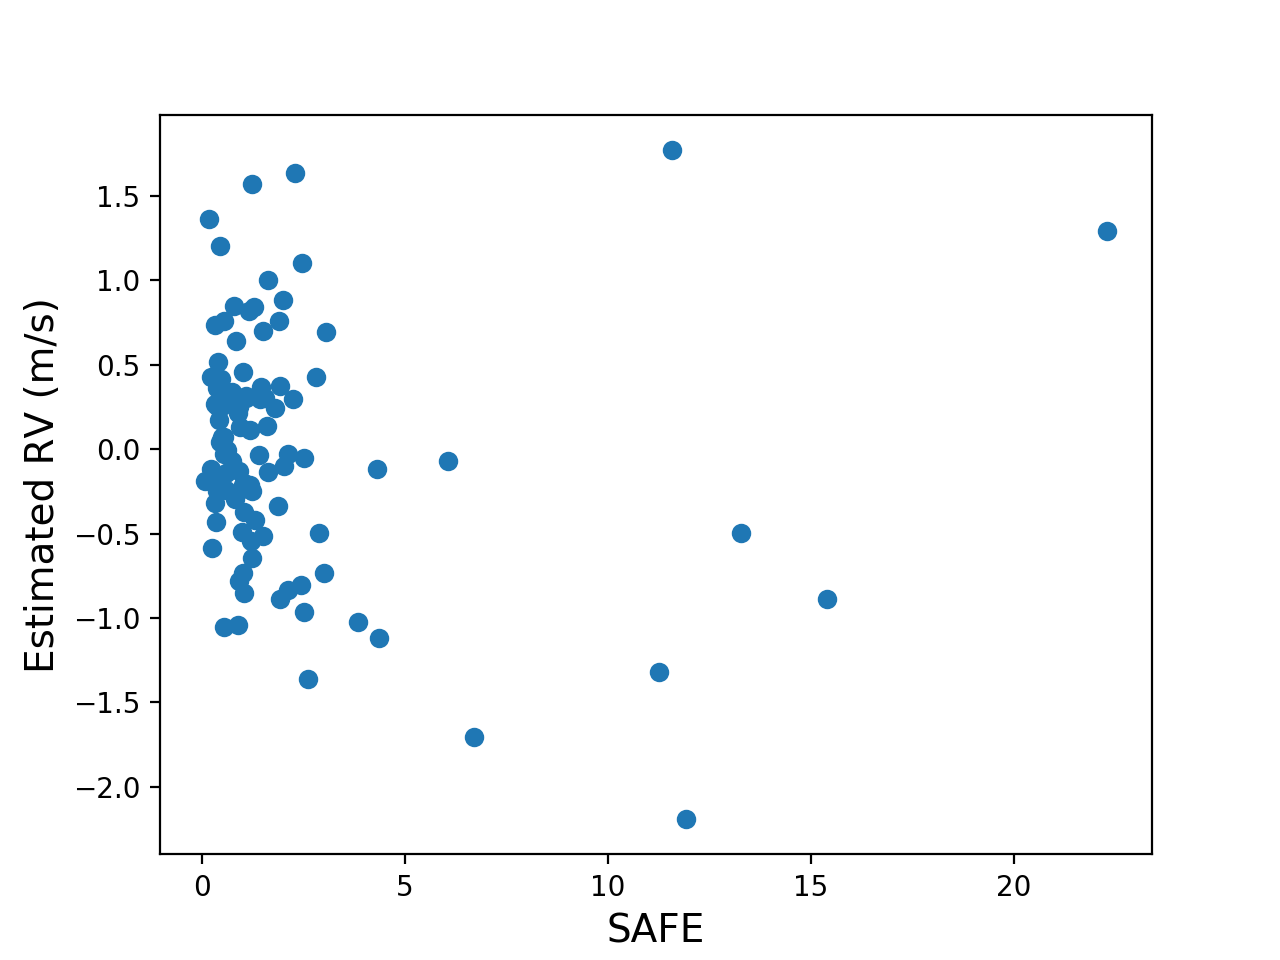

In [8]:
rv = pd.read_csv("HGRV_rvs.csv")
plt.scatter(safe5.SAFE.values, rv.RV.values)
plt.xlabel("SAFE", fontsize=14)
plt.ylabel("Estimated RV (m/s)", fontsize=14)
plt.show()